In [31]:
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.stats import norm
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_theme() 

## Deep Hedging for Option Replication

This notebook implements **Deep Hedging**, a neural-network-based strategy to replicate and hedge derivative contracts under market frictions like transaction costs. Unlike traditional Delta hedging, Deep Hedging learns the strategy end-to-end by directly optimizing the hedging profit-and-loss (PnL).

## Asset

This class simulates asset price trajectories under the risk-neutral measure, using a discretized geometric Brownian motion (GBM).

**Attributes:**
- `s0` : Initial asset price.
- `r` : Constant risk-free interest rate.
- `sigma` : Volatility of the asset.
- `div` : Continuous dividend yield.
- `T` : Maturity of the option (in years).
- `N` : Number of time steps.
- `M` : Number of Monte Carlo paths.
- `delta` : Time step size $\Delta_t = T / N$

In [32]:
class Asset:
    def __init__(self, s0, r, sigma, div = 0, T = 3, N = 9, M = 8192, d = 3, device = "cpu"):
        self.N = N
        self.M = M
        self.d = d
        self.T = T
        self.delta = T / N
        self.s0 = s0
        self.r = r
        self.sigma = sigma
        self.div = div
        self.device = device

    def brownian_paths(self, noise):
        dB = torch.zeros((noise.shape), device = self.device)
        dB[1:] = torch.sqrt(torch.tensor(self.delta, device = self.device)) * noise[1:]
        B = torch.cumsum(dB, axis = 0)

        return B

    def asset_paths(self, scenario_size = None):
        M = scenario_size or self.M

        noise = torch.randn(size = (self.N + 1, M, self.d), device = self.device)
        B = self.brownian_paths(noise)
        tn = (torch.arange(self.N + 1, device = self.device) * self.delta)[:, None, None]

        S = self.s0 * torch.exp((self.r - self.div - 0.5 * self.sigma ** 2) * tn + self.sigma * B)

        return S


## Option Payoff Classes

Options are defined on the maximum of the `d` assets. Two contracts are implemented:

- `MaxCallOption` : payoff = $\max(\max(S) - K, 0)$
- `MaxPutOption` : payoff = $\max(K - \max(S), 0)$

Methods:
- `payoff(X, n)` : returns discounted payoff at time `n`.
- `BS_price()` : computes the Black-Scholes price of the equivalent European option (for `d = 1`).

In [33]:
class MaxPutOption():
    def __init__(self, asset, K, device = "cpu"):
        self.asset = asset
        self.K = K
        self.device = device

    def payoff(self, X, n = None, discounted = True):
        max_value = torch.max(X, axis = -1)[0]
        payoff_value = torch.relu(self.K - max_value)
        if discounted :
            tn = (torch.arange(X.shape[0], device = self.device) * self.asset.delta)[:, None]
            payoff_value = torch.exp(- self.asset.r * tn) * payoff_value

        return payoff_value[n] if n is not None else payoff_value
    
    def BS_price(self):
        d_plus = (np.log(self.asset.s0 / self.K) + (self.asset.r + 0.5 * self.asset.sigma ** 2) * self.asset.T) / (self.asset.sigma * np.sqrt(self.asset.T))
        d_minus = d_plus - self.asset.sigma * np.sqrt(self.asset.T)
        return self.K * np.exp(-self.asset.r * self.asset.T) * norm.cdf(-d_minus) - self.asset.s0 * norm.cdf(-d_plus)
    
class MaxCallOption():
    def __init__(self, asset, K, device = "cpu"):
        self.asset = asset
        self.K = K
        self.device = device

    def payoff(self, X, n = None, discounted = True):
        max_value = torch.max(X, axis = -1)[0]
        payoff_value = torch.relu(max_value - self.K)
        if discounted :
            tn = (torch.arange(X.shape[0], device = self.device) * self.asset.delta)[:, None]
            payoff_value = torch.exp(- self.asset.r * tn) * payoff_value

        return payoff_value[n] if n is not None else payoff_value
    
    def BS_price(self):
        d_plus = (np.log(self.asset.s0 / self.K) + (self.asset.r + 0.5 * self.asset.sigma ** 2) * self.asset.T) / (self.asset.sigma * np.sqrt(self.asset.T))
        d_minus = d_plus - self.asset.sigma * np.sqrt(self.asset.T)
        return self.asset.s0 * norm.cdf(d_plus) - self.K * np.exp(-self.asset.r * self.asset.T) * norm.cdf(d_minus)

## Neural Network Architecture

The `Network` class defines the hedging model:
- Inputs : asset prices + time to maturity (shape `(M, d + 1)`).
- Outputs : hedge ratios (deltas), shape `(M, d)`.
- Layers : Dense layers with ReLU activations and BatchNorm.
- Final activation : Sigmoid to ensure bounded hedge ratios.

In [34]:
class Network(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = []
        
        layers.append(nn.Linear(input_size, layer_sizes[0]))
        layers.append(nn.BatchNorm1d(layer_sizes[0]))
        layers.append(nn.ReLU())

        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.BatchNorm1d(out_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(layer_sizes[-1], output_size))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## DeepHedging Class

This is the core of the method :
- Learns optimal dynamic hedging strategy.
- Handles transaction costs.

### Methods:
- `train()` : fits the model to minimize hedging PnL error.
- `calculate_pnl()` : returns PnL with and without hedge.
- `analyze_pnl_distribution()` : visualizes PnL histogram + confidence interval.
- `analyse_deltas()` : plots learned delta vs. price.

In [37]:
class DeepHedging:
    def __init__(self, asset, option, layers, bid_ask_spread=0, device="cpu"):
        """
        Initializes the Deep Hedging model using a neural network.

        Parameters:
        - asset : Object simulating the underlying asset dynamics.
        - option : Option contract to replicate.
        - layers : List of integers, the neural network architecture.
        - bid_ask_spread : Transaction cost percentage (e.g., 0.01 for 1% spread).
        - device : 'cpu' or 'cuda'.
        """
        self.asset = asset
        self.option = option
        self.device = device
        self.layers = layers
        self.bid_ask_spread = bid_ask_spread
        self.theta = self.initialize_model()

    def initialize_model(self):
        """
        Initializes the neural network model used to learn the hedging strategy.

        Returns:
        - PyTorch model (Network)
        """
        return Network(
            input_size=self.asset.d + 1,  # asset prices + time
            layer_sizes=self.layers,
            output_size=self.asset.d     # hedge ratios per asset
        ).to(self.device)

    def train(self, epoch=1000, batch_size=8192, learning_rate=1e-3):
        """
        Trains the neural network by minimizing the squared hedging PnL error.

        Parameters:
        - epoch : Number of training epochs.
        - batch_size : Batch size for training.
        - learning_rate : Optimizer learning rate.
        """
        optimizer = torch.optim.Adam(self.theta.parameters(), lr=learning_rate)

        for _ in tqdm(range(epoch)):
            S_batch = self.asset.asset_paths(batch_size)
            payoff_batch = self.option.payoff(S_batch, self.asset.N)

            tn = torch.arange(self.asset.N + 1, device=self.device)[:, None, None] * self.asset.delta
            discounted_S_batch = torch.exp(-self.asset.r * tn) * S_batch
            discounted_dS = discounted_S_batch[1:] - discounted_S_batch[:-1]

            discounted_delta_pnl = torch.zeros(batch_size, device=self.device)
            time_remaining = self.asset.T - tn[:-1]
            deltas = torch.zeros((self.asset.N, batch_size, self.asset.d), device=self.device)

            for t in range(self.asset.N):
                discounted_S_t = discounted_S_batch[t]
                time_t = time_remaining[t].repeat(batch_size, 1)
                model_input = torch.cat([discounted_S_t, time_t], dim=-1)
                deltas[t] = self.theta(model_input)

                if t == 0:
                    portfolio_change = deltas[0]
                else:
                    portfolio_change = deltas[t] - deltas[t - 1]

                transaction_cost = self.bid_ask_spread * torch.abs(discounted_S_t * portfolio_change).sum(dim=-1)
                discounted_delta_pnl += (deltas[t] * discounted_dS[t]).sum(dim=-1) - transaction_cost

            P0 = self.option.BS_price()
            loss = torch.mean((P0 - payoff_batch + discounted_delta_pnl) ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def calculate_pnl(self, S):
        """
        Computes the PnL of the hedged and unhedged strategies.

        Parameters:
        - S : torch.Tensor of shape (N + 1, M, d), simulated asset paths.

        Returns:
        - pnl_no_hedge : NumPy array of shape (M,), PnL without hedging.
        - pnl_hedge : NumPy array of shape (M,), PnL with learned hedge.
        - deltas : torch.Tensor of shape (N, M, d), hedge ratios.
        """
        payoff = self.option.payoff(S, self.asset.N)

        tn = torch.arange(self.asset.N + 1, device=self.device)[:, None, None] * self.asset.delta
        discounted_S = torch.exp(-self.asset.r * tn) * S
        discounted_dS = discounted_S[1:] - discounted_S[:-1]

        discounted_delta_pnl = torch.zeros(S.shape[1], device=self.device)
        time_remaining = self.asset.T - tn[:-1]
        deltas = torch.zeros((self.asset.N, S.shape[1], self.asset.d), device=self.device)

        for t in range(self.asset.N):
            discounted_S_t = discounted_S[t]
            time_t = time_remaining[t].repeat(S.shape[1], 1)
            model_input = torch.cat([discounted_S_t, time_t], dim=-1)
            deltas[t] = self.theta(model_input)

            if t == 0:
                portfolio_change = deltas[0]
            else:
                portfolio_change = deltas[t] - deltas[t - 1]

            transaction_cost = self.bid_ask_spread * torch.abs(discounted_S_t * portfolio_change).sum(dim=-1)
            discounted_delta_pnl += (deltas[t] * discounted_dS[t]).sum(dim=-1) - transaction_cost

        P0 = self.option.BS_price()
        pnl_hedge = P0 - payoff + discounted_delta_pnl
        pnl_no_hedge = P0 - payoff

        return pnl_no_hedge.detach().cpu().numpy(), pnl_hedge.detach().cpu().numpy(), deltas.detach().cpu()

    def analyze_pnl_distribution(self, pnl, confidence_level=0.95):
        """
        Displays summary statistics and histogram of the PnL distribution.

        Parameters:
        - pnl : array-like, list of PnL samples.
        - confidence_level : float, confidence interval level (default 0.95).
        """
        mean_pnl = np.mean(pnl)
        var_pnl = np.var(pnl, ddof=1)
        alpha = 1 - confidence_level
        quantile = stats.norm.ppf(1 - alpha / 2)
        ci_lower = mean_pnl - quantile * np.sqrt(var_pnl / pnl.shape[0])
        ci_upper = mean_pnl + quantile * np.sqrt(var_pnl / pnl.shape[0])

        print(f"\n=== PnL Results ===")
        print(f"Estimated Mean PnL      : {mean_pnl:.6f}")
        print(f"Estimated Variance PnL  : {var_pnl:.6f}")
        print(f"Confidence Level        : {confidence_level*100:.1f}%")
        print(f"Confidence Interval     : [{ci_lower:.6f}, {ci_upper:.6f}]\n")

        plt.hist(pnl, bins=20, density=True)
        plt.title("PnL Distribution")
        plt.xlabel("PnL")
        plt.ylabel("Density")
        plt.show()

    def analyse_deltas(self, paths, deltas):
        """
        Plots the hedge ratio (delta) as a function of asset price at different times.

        Parameters:
        - paths : np.ndarray of shape (N + 1, M, d), simulated asset paths.
        - deltas : np.ndarray of shape (N, M, d), hedging deltas from the model.
        """
        _, ax = plt.subplots()
        num_points = 1000
        num_paths = 10 if self.asset.N > 10 else self.asset.N
        total_points = paths.shape[1]
        step = max(total_points // num_points, 1)

        time_indices = np.arange(num_paths, self.asset.N, num_paths) if self.asset.N > num_paths else np.arange(1, self.asset.N)

        for n in time_indices:
            prices = paths[n, :, 0]
            sorted_indices = np.argsort(prices)
            sorted_prices = prices[sorted_indices]
            sorted_deltas = deltas[n, sorted_indices, 0]

            ax.plot(sorted_prices, sorted_deltas, lw=2, label=f'Hedging at time {n}')

        ax.set_title("Deep Hedging Strategy: Delta vs. Underlying Price")
        ax.set_xlabel("Underlying Asset Price")
        ax.set_ylabel("Delta (Hedging Position)")
        ax.legend()
        plt.show()

## Experiments

### No Transaction Cost
- Train model with zero bid-ask spread.
- Evaluate hedge quality via PnL histograms.

100%|██████████| 1000/1000 [00:24<00:00, 41.63it/s]



=== PnL Results ===
Estimated Mean PnL      : 14.888690
Estimated Variance PnL  : 216.438950
Confidence Level        : 95.0%
Confidence Interval     : [14.797507, 14.979873]



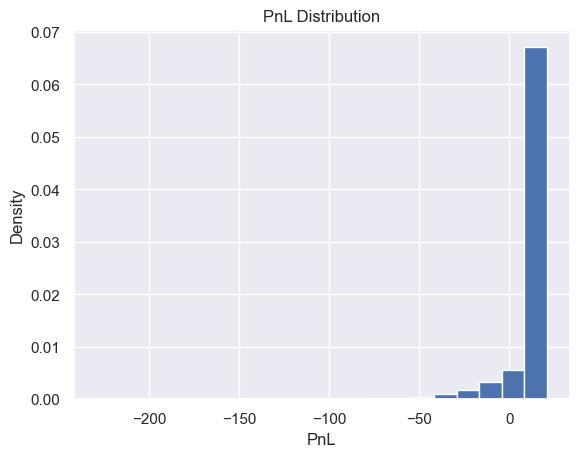


=== PnL Results ===
Estimated Mean PnL      : 0.355761
Estimated Variance PnL  : 19.748867
Confidence Level        : 95.0%
Confidence Interval     : [0.328217, 0.383304]



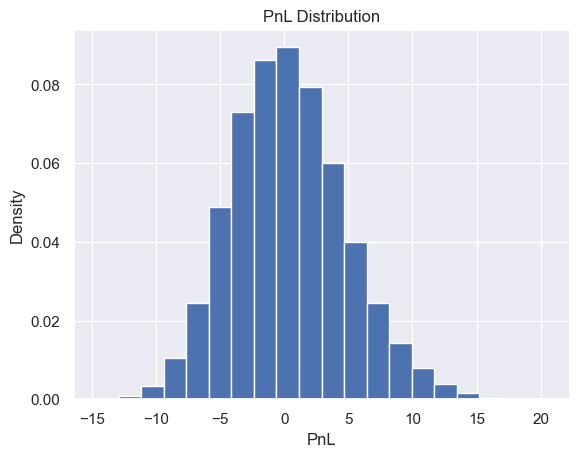

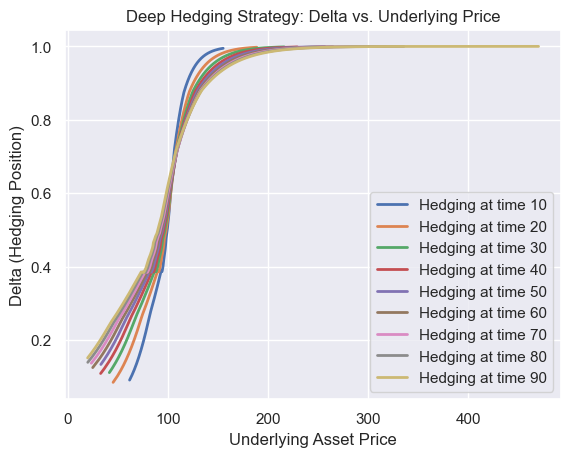

In [38]:
S = Asset(s0 = 100, 
          r = 0.05, 
          div = 0.1, 
          sigma = 0.2, 
          T = 3, 
          N = 100, 
          M = 8192,
          d = 1)

option = MaxCallOption(S, K = 100)

model = DeepHedging(S, option, layers = [16,16], bid_ask_spread = 0)
model.train(epoch = 1000, batch_size = 512)

paths = S.asset_paths(scenario_size = 100_000)
pnl_no_hedge, pnl_hedge, deltas_no_cost = model.calculate_pnl(paths)

model.analyze_pnl_distribution(pnl_no_hedge)
model.analyze_pnl_distribution(pnl_hedge)
model.analyse_deltas(paths, deltas_no_cost)

### Mid Transaction Cost
- Repeat experiment with spread = 0.001.
- Observe degradation in hedge quality.

100%|██████████| 1000/1000 [00:26<00:00, 37.88it/s]



=== PnL Results ===
Estimated Mean PnL      : 8.619536
Estimated Variance PnL  : 240.915375
Confidence Level        : 95.0%
Confidence Interval     : [8.523335, 8.715738]



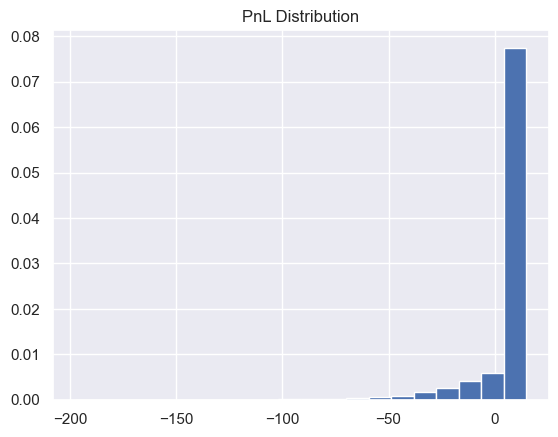


=== PnL Results ===
Estimated Mean PnL      : -7.521190
Estimated Variance PnL  : 60.556805
Confidence Level        : 95.0%
Confidence Interval     : [-7.569422, -7.472959]



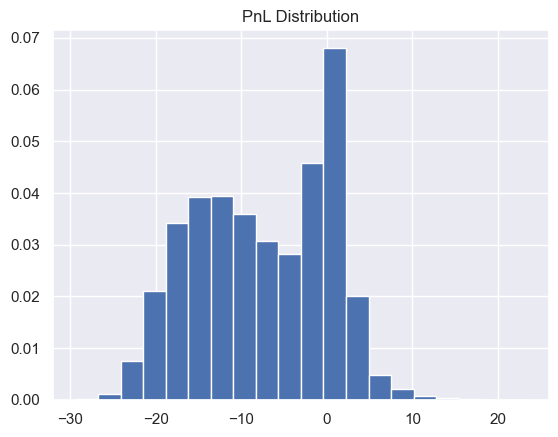

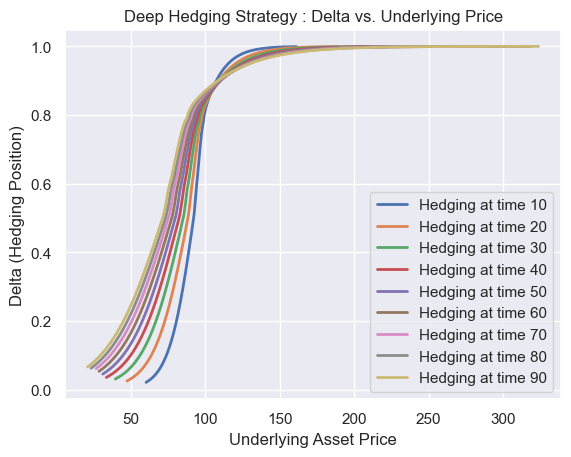

In [28]:
S = Asset(s0 = 100, 
          r = 0.1, 
          sigma = 0.25,
          T = 1, 
          N = 100, 
          M = 8192, 
          d = 1)
option = MaxCallOption(S, K = 100)

model = DeepHedging(S, option, layers = [16,16], bid_ask_spread = 0.001)
model.train(epoch = 1000, batch_size = 512)

pnl_no_hedge, pnl_hedge, deltas_mid_cost = model.calculate_pnl(paths)

model.analyze_pnl_distribution(pnl_no_hedge)
model.analyze_pnl_distribution(pnl_hedge)
model.analyse_deltas(paths, deltas_mid_cost)

### Mid Transaction Cost
- Repeat experiment with spread = 0.01.
- Observe further degradation in hedge quality.

100%|██████████| 1000/1000 [00:26<00:00, 37.12it/s]



=== PnL Results ===
Estimated Mean PnL      : 8.619536
Estimated Variance PnL  : 240.915375
Confidence Level        : 95.0%
Confidence Interval     : [8.523335, 8.715738]



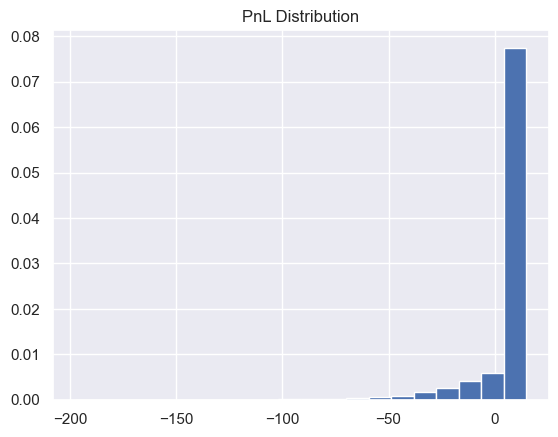


=== PnL Results ===
Estimated Mean PnL      : -9.846698
Estimated Variance PnL  : 66.659172
Confidence Level        : 95.0%
Confidence Interval     : [-9.897301, -9.796095]



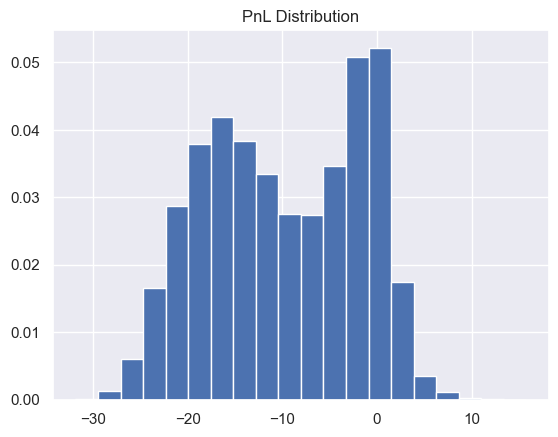

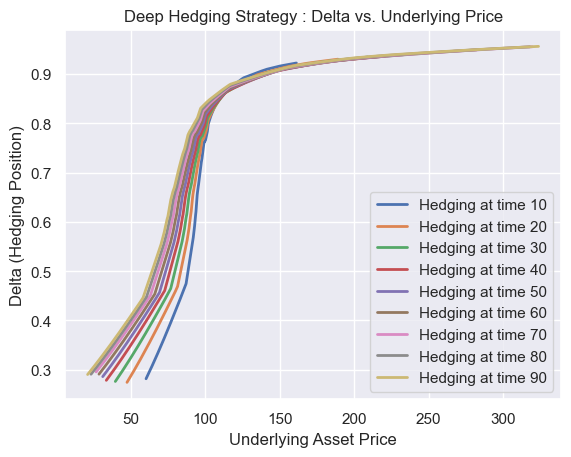

In [29]:
S = Asset(s0 = 100, 
          r = 0.1, 
          sigma = 0.25,
          T = 1, 
          N = 100, 
          M = 8192, 
          d = 1)
option = MaxCallOption(S, K = 100)

model = DeepHedging(S, option, layers = [16,16], bid_ask_spread = 0.01)
model.train(epoch = 1000, batch_size = 512)

pnl_no_hedge, pnl_hedge, deltas_high_cost = model.calculate_pnl(paths)

model.analyze_pnl_distribution(pnl_no_hedge)
model.analyze_pnl_distribution(pnl_hedge)
model.analyse_deltas(paths, deltas_high_cost)

### Impact of Spread on Final Hedge
- Train a separate model for various spreads.
- Plot delta as function of price at maturity

Training Deep Hedging Model with spread = 0.0000


100%|██████████| 1000/1000 [00:25<00:00, 38.64it/s]


Training Deep Hedging Model with spread = 0.0020


100%|██████████| 1000/1000 [00:26<00:00, 38.24it/s]


Training Deep Hedging Model with spread = 0.0040


100%|██████████| 1000/1000 [00:26<00:00, 37.87it/s]


Training Deep Hedging Model with spread = 0.0060


100%|██████████| 1000/1000 [00:27<00:00, 36.15it/s]


Training Deep Hedging Model with spread = 0.0080


100%|██████████| 1000/1000 [00:27<00:00, 36.29it/s]


Training Deep Hedging Model with spread = 0.0100


100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]


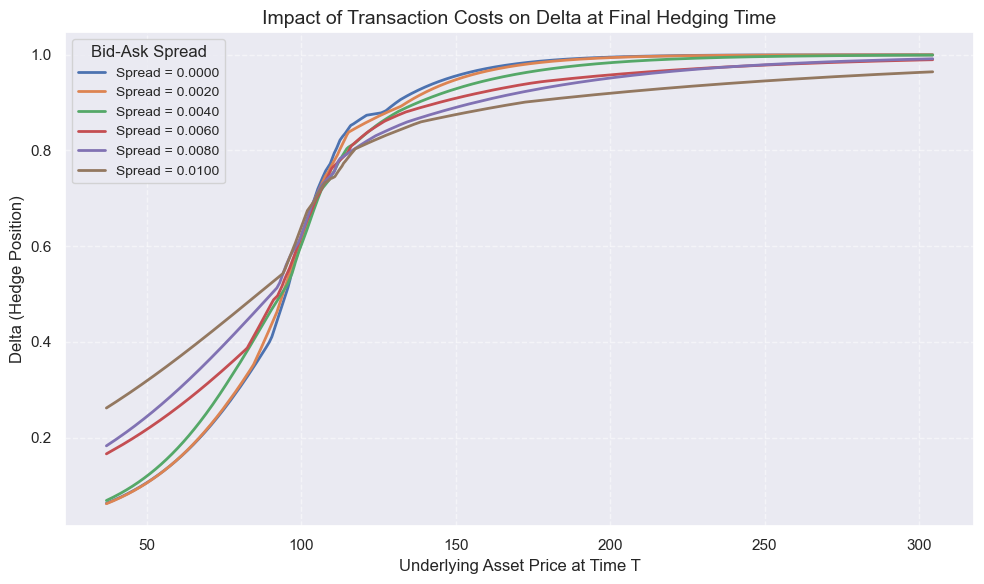

In [36]:
S = Asset(s0 = 100, 
          r = 0.1, 
          sigma = 0.25,
          T = 1, 
          N = 100, 
          M = 8192, 
          d = 1)

option = MaxCallOption(S, K = 100)

spread_values = np.linspace(0, 0.01, 6)
paths = S.asset_paths(scenario_size = 100_000)

final_deltas = []

for spread in spread_values:
    print(f"Training Deep Hedging Model with spread = {spread:.4f}")
    model = DeepHedging(S, option, layers=[16, 16], bid_ask_spread=spread)
    model.train(epoch = 1000, batch_size = 512)

    _, _, delta_spread = model.calculate_pnl(paths)
    final_deltas.append(delta_spread)

_, ax = plt.subplots(figsize=(10, 6))

for delta, spread in zip(final_deltas, spread_values):
    prices = paths[S.N - 1, :, 0]
    sorted_indices = np.argsort(prices)

    sorted_prices = prices[sorted_indices]
    sorted_deltas = delta[S.N - 1, sorted_indices, 0]

    ax.plot(sorted_prices, sorted_deltas, lw=2, label=f'Spread = {spread:.4f}')

ax.set_title("Impact of Transaction Costs on Delta at Final Hedging Time", fontsize=14)
ax.set_xlabel("Underlying Asset Price at Time T", fontsize=12)
ax.set_ylabel("Delta (Hedge Position)", fontsize=12)
ax.legend(title="Bid-Ask Spread", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Conclusion

Deep Hedging provides a flexible and robust way to learn optimal hedging strategies in complex market environments. Its strengths :
- Handles high-dimensional assets.
- No need for closed-form solutions.
- Learns optimal behavior in presence of costs.

This framework opens doors to more realistic hedging under constraints encountered in practice.